In [20]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools as itrt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from itertools import repeat
from functools import partial
from scipy.stats import chi2
from scipy.stats import norm
from scipy import integrate
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm

#### ALL SIGNAL AND BGND PDFS HAVE BEEN WRITTEN TO .TXT FILES

In [21]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()



#Importing UPtime data
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()


#Importing Aeff data
filenames = ["IC40_effectiveArea.csv", "IC59_effectiveArea.csv","IC79_effectiveArea.csv", "IC86_I_effectiveArea.csv", "IC86_II_effectiveArea.csv"]
file = filenames[0]
f = open(os.path.join(irf_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
eadata = []
for file in filenames:
    content = []
    f = open(os.path.join(irf_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column, dtype=float)
    #temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    #temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    eadata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read
IC40_effectiveArea.csv read
IC59_effectiveArea.csv read
IC79_effectiveArea.csv read
IC86_I_effectiveArea.csv read
IC86_II_effectiveArea.csv read


In [51]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
ictimes = [float(i) for i in icdata['MJD[days]']]
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]  #paritions of icdata for each season (IC40, IC59, IC79, IC86_I, IC86_II)
#icparts.pop(-1)
#icparts
upt_icparts = icparts[:5]
upt_icparts.append(icparts[-1])
#len(upt_icparts) - 1 == len(eadata)

log_e = np.round(np.arange(2, 10.2, 0.2), 2) #log10(E/GeV) values range as in all 'effectiveArea' files

#dec_nu = mid point of Dec_nu_min and Dec_nu_max as in all 'effectiveArea' files
dec_nu = list(set(eadata[0]['Dec_nu_min[deg]'].values).union(set(eadata[0]['Dec_nu_max[deg]'].values)))

dec_nu.sort()
dec_nu = np.asarray(dec_nu)

e_nu = ((10**(log_e[:-1])+ 10**(log_e[1:]))/2)*1e9
#de_nu = 1e9**0.2
de_nu = 1e9*(10**log_e[1:] - 10**log_e[:-1])
#Test case for e_ind
nu_e = 5
e_ind = 0
for i in range(len(log_e) - 1):
    if nu_e >= log_e[i] and nu_e < log_e[i+1]:
        e_ind = i
print([e_ind, i])

[15, 39]


Importing ATNF Pulsar data

In [52]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


#### Vectorizing important & frequently used values

#### msra/dec store the ra/dec values of the pulsars

#### icra/dec store the ra/dec values of the neutrino events

#### icang stores the angular uncertainity

#### iceng stores the log(energy/GeV) of the neutrino events

In [53]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
iceng = np.array([float(i) for i in icdata['log10(E/GeV)']])
global p, lg, lnu
p = len(msra)
lg = len(icra) // p + 1
lnu = len(icra)
[min(icdec), max(icdec)]

[-89.957, 89.977]

In [54]:
upstop_ttt = np.asfarray([uptdata[i]['MJD_stop[days]'].values[-1] for i in range(len(uptdata))])
upstart_ttt = np.asfarray([uptdata[i]['MJD_start[days]'].values[0] for i in range(len(uptdata))])
earea = np.array([eadata[i]['A_Eff[cm^2]'].values for i in range(len(eadata))])# * 1e-4
vec_uptparts = np.asarray(upt_icparts, dtype=np.int64)
upt_icparts = np.asarray(upt_icparts)

In [55]:
upstop_ttt

array([54971.15026394, 55347.28439144, 55694.41019675, 56062.41831018,
       56414.41614583, 56783.57893518, 57160.04101851, 57528.85952546,
       57891.16406249, 58309.08234953])

In [56]:
t_upt = np.asarray([upstop_ttt[season] - upstart_ttt[season] for season in range(len(upstart_ttt))])*86400

In [172]:
@jit(nopython=True, fastmath=True)
def Pr(x, Ns, S, B):

    '''
    Parameters
    ----------
    x : int
        Assumed no.of associated events

    Ns : int
        No.of neutrinos used for analysis

    S : float
        Signal PDF
    B : float
        Background PDF
    
    Returns
    -------
    float 
        Returns the probability of the selected set of neutrinos being associated\n
        with a given pulsar with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


@jit(nopython=True, fastmath=True)
def wall_nu(nu):
    
        '''
        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        
    
        Returns
        -------
        int
            Returns the index of the wall in which the {nu}th neutrino lies
        '''
        wall = 0
        for i in range(len(vec_uptparts)-1):
            if vec_uptparts[i] <= nu and vec_uptparts[i+1] > nu:
                wall = i
                break        
        return wall


@jit(nopython=True, fastmath=True)
def TS_st(x, S, B, Ns):

    ''' 
    Returns
    ----------
        Returns the Test Stastic value at
        $n_s$ = {x} for its parameters S, B, Ns
    '''
    if x >=0:
        return np.sum(np.asfarray(2*np.log(Pr(x,  Ns, S, B)/B)))
    else:
        return -1

def ns_for_TSmax_st(S, B, Ns):
    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st(x, S, B, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]
    #print(soln.success)
    return ns

Ns = lnu#np.count_nonzero(nuind+1)
@njit(parallel=True, fastmath=True)
def Ts_arr(x, S_all, B_all, Ns):
    '''
    Parameters
    ----------
    x : float
        The value of x for which the TS is to be calculated

    S_all : array
        The array of signal PDFs for all the neutrinos

    B_all : array
        The array of background PDFs for all the neutrinos
    
    Ns : int
        The number of neutrinos

    Returns
    -------
    float
        The TS value for the entire stack of neutrinos for the given value of x
    
    '''


    #Ts_arr = lambda x:
    sum = 0.0
    for i in range(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum

@njit(fastmath=True)
def Ts_arr2(x, S_all, B_all, Ns):
    '''
    Parameters
    ----------
    x : float
        The value of x for which the TS is to be calculated

    S_all : array
        The array of signal PDFs for all the neutrinos

    B_all : array
        The array of background PDFs for all the neutrinos
    
    Ns : int
        The number of neutrinos

    Returns
    -------
    float
        The TS value for the entire stack of neutrinos for the given value of x
    
    '''


    #Ts_arr = lambda x:
    sum = 0.0
    for i in prange(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum



In [173]:
sigfilepath = "/media/darkwake/VIB2/Project-IceCube/task4/outputs/"
bgfilepath = "/media/darkwake/VIB2/Project-IceCube/task4/outputs/all_Bi.txt"

gamma_arr = [-1, -2, -2.5, -3]
all_sig = []
for i in range(4):
    all_sig.append(np.loadtxt(sigfilepath + "sigbag_nu" + str(gamma_arr[i]) + ".txt"))

all_sig = np.asfarray(all_sig)
all_bg = np.loadtxt(bgfilepath)
all_bg = np.asfarray(all_bg)

![SNOWFALL](stnu.png)

$\hat{n}_s = 2\pi \sum_k t_k \sum_j \dfrac{sin(\delta_{j+1}) - sin(\delta_j)}{\delta_{j+1} - \delta_j}\sum_{\nu} A_{eff}^k (E_\nu, \delta_j) \dfrac{dF}{dE_\nu}$

$\dfrac{dF}{dE} = \phi_0 \{\dfrac{E_{\nu}}{100 TeV}\}^\Gamma$

In [224]:
@njit(fastmath=True)
def dfde(e_nu, gamma, phi0 = 1e-40):
    '''
    Parameters
    ----------
    e_nu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    phi0 : float (optional)
        The normalization constant of the neutrino flux
    
    Returns
    -------
    float
        The differential flux of neutrinos
    '''

    return phi0 * ((e_nu/(10**14))**gamma)

@njit(parallel=True, fastmath=True)
def dfde_p(e_nu, gamma, phi0 = 1.0):
    '''
    Parameters
    ----------
    e_nu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    phi0 : float (optional)
        The normalization constant of the neutrino flux
    
    Returns
    -------
    float
        The differential flux of neutrinos
    '''

    return phi0 * ((e_nu/(10**14))**gamma)

## THIS IS THE CORRECT WAY!!!!!!!

In [225]:
len(t_upt)

10

In [226]:
@njit(fastmath=True)
def upt_season(nu):
    for i in range(len(upt_icparts)):
        if upt_icparts[i] > nu:
            return ea_season(i-1)
    return -1

        
@njit(fastmath=True)
def ea_season(season):
    if season == 0:
        return 0
    elif season == 1:
        return 1
    elif season == 2:
        return 2
    elif season == 3:
        return 3
    elif season >= 4 and season <= 10:
        return 4
    else:
        return -1

In [227]:
@njit(fastmath=True)
def earea_r(season, i, j):
    se =  np.int32(ea_season(season))
    return earea[se][i + 40*j]

In [228]:
gamma_arr = np.asarray([-1, -2, -2.5, -3])

In [229]:
@njit(fastmath=True)
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0=1e-40, season=0):
    tt_upt = t_upt[season]
    if enu <= 1e11 or enu > 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu)):
            if e_nu[i] <= enu and e_nu[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        k=i
                        l=j
                        break
                break

        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * (enu**2) * temp_ea * dfde(enu, gamma, phi0)

@njit(fastmath=True)
def ns_singleseason_sing_nu_HAT(nu, gamma, phi0=1e-40):
    dec = icdec[nu]
    enu = (10**iceng[nu])*1e9
    season = upt_season(nu)
    tt_upt = t_upt[season]
    if enu <= 1e11 or enu > 1e19:
        return 0
    
    else:
        i=0
        j=0
        for i in range(0, len(e_nu)):
            if e_nu[i] <= enu and e_nu[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        break
                break
        season = ea_season(season)
        temp_ea = np.asarray(earea[season])[j*40 + i]
        return float(tt_upt * (enu**2) * temp_ea * dfde(enu, gamma, phi0))



ns_singleseason_sing_nu_HAT(1, 1e18, -2, 1e-40)

In [230]:
ns_singleseason_sing_nu_HAT(1, -2, 1e-40)

1.169077426624411

In [231]:
for i in range(4):
    print(ns_singleseason_sing_nu_HAT(1, gamma_arr[i], 1e-40))

1.7291922281382694
1.169077426624411
0.9612653212609583
0.7903933450558327


In [232]:
pool = mul.Pool(8, maxtasksperchild=10)

In [233]:
ns_all_nu_all_gamma = []
for gamma in gamma_arr:
#gamma = -2
#nll = lambda x: ns_singleseason_sing_nu_HAT(x, gamma, 1e-40)

    def nll(x):
        return ns_singleseason_sing_nu_HAT(x, gamma, 1e-40)
    
    pool = mul.Pool(8, maxtasksperchild=10)
    op_async = pool.map_async(nll, range(lnu))
    ns_all_nu_sing_gamma = op_async.get()
    ns_all_nu_all_gamma.append(ns_all_nu_sing_gamma)
    pool = []
    op_async = []
    


In [234]:
np.shape(ns_all_nu_all_gamma)

(4, 1134450)

In [235]:
ictrueeng = (10**iceng)*1e9

In [240]:
ictrueeng.min()/1e9

11.220184543019636

In [241]:
all_eng = []
for gamma in gamma_arr:
    def nll(x):
        return dfde(x, gamma, 1e-40)
    
    pool = mul.Pool(8, maxtasksperchild=10)
    op_async = pool.map_async(nll, ictrueeng)
    all_eng.append(op_async.get())
    pool = []
    op_async = []

In [244]:
np.shape(all_eng)

(4, 1134450)

In [247]:
all_e2dfde = np.asarray([np.multiply(np.square(ictrueeng), i) for i in all_eng])

In [248]:
all_e2dfde.shape

(4, 1134450)

In [252]:
all_Ts = []
for i in range(4):
    def nll(x):
        return Ts_arr2(x, all_sig[i], all_bg, lnu)
    pool = mul.Pool(12, maxtasksperchild=1000)
    op_async = pool.map_async(nll, ns_all_nu_all_gamma[i][:10000])
    all_Ts.append(op_async.get())
    pool = []
    op_async = []


In [261]:
all_e2dfde[0][:]

array([2.04173794e-14, 1.47910839e-12, 8.31763771e-14, ...,
       7.58577575e-15, 9.54992586e-15, 1.90546072e-14])

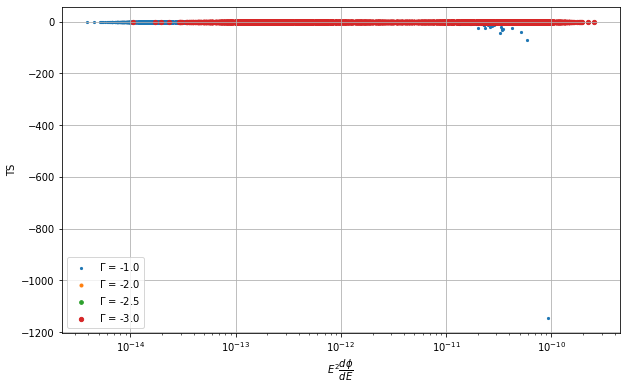

In [278]:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.scatter(all_e2dfde[i][:len(all_Ts[i])],all_Ts[i],  label='$\Gamma$ = '+ str(gamma_arr[i]), s = (i+1)*4.6)

plt.xlabel('$E^2 \dfrac{d\phi}{dE}$')
plt.ylabel('TS')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc = 'best')
plt.grid()
plt.show()

In [281]:
0.228*lnu/86400

2.9936875

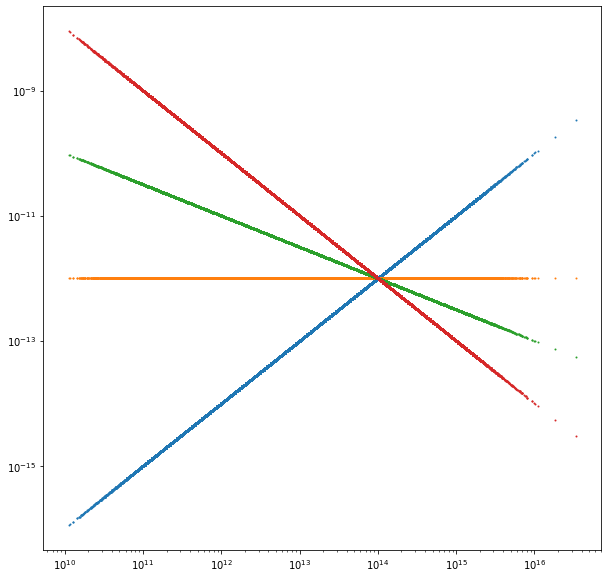

In [249]:
plt.figure(figsize=(10, 10))
plt.scatter(ictrueeng, all_e2dfde[0], s=1)
plt.scatter(ictrueeng, all_e2dfde[1], s=1)
plt.scatter(ictrueeng, all_e2dfde[2], s=1)
plt.scatter(ictrueeng, all_e2dfde[3], s=1)
plt.xscale('log')
plt.yscale('log')
plt.show()


season = 2
psrdec = icdec[1]
enu = 1e17
gamma = -2
phi0 = 1e-32
t_upt = (upstop_ttt[season] - upstart_ttt[season])*86400

for i in range(0, len(e_nu)):
    if e_nu[i] <= enu and e_nu[i+1] > enu:
        for j in range(0, len(dec_nu)):
            if dec_nu[j] <= psrdec and dec_nu[j+1] > psrdec:
                break
        break
                
ea_season = [0, 1, 2, 3, 4, 4, 4, 4, 4, 4]
a = np.arange(i, 2001, 40)[j]
temp_ea = np.array(earea[ea_season[season]])[a]
sin_delta = np.sin(np.deg2rad(psrdec))
        
print( t_upt * (enu**2) * temp_ea * dfde(enu, gamma, phi0))#*sin_delta)

In [ ]:
nll = lambda x: Ts_arr2(ns_singleseason_sing_psr_HAT(icdec[x], enu, gamma_arr, x, phi0), all_sig[2], all_bg, lnu)

def season(nu):
    for i in range(10):
        if nu >= icparts[i] and nu < icparts[i+1]:
            return i


def ns_all_season_all_nu_HAT(enu, gamma, phi0):
    ns_all_season = 0
    nll = lambda x: Ts_arr2(ns_singleseason_sing_psr_HAT(icdec[x], enu, gamma, x, phi0, season), all_sig[2], all_bg, lnu)
    pool = mul.Pool(10, maxtasksperchild=100)
    op_async = pool.map_async()



    for nu in range(lnu):
        for season in range(10):
            ns_all_season += ns_singleseason_sing_psr_HAT(icdec[nu], enu, gamma, phi0, season)
    return ns_all_season